<h1 style="background-color:#0071BD;color:white;text-align:center;padding-top:0.8em;padding-bottom: 0.8em">
Expectation Maximization for Gaussian Mixture Models
</h1>

Accompanying notebook for the lecture slides:

  * Christian Bauckhage: "Lectures on Pattern Recognition", Add-on to Lecture 14: "Expectation Maximization for Gaussian Mixture Models", December 2017 ([Download from ReseachGate](https://www.researchgate.net/project/lectures-on-pattern-recognition/update/5a3e23734cde266d587d382f))

<p style="background-color:#66A5D1;padding-top:0.2em;padding-bottom: 0.2em" />

In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rnd

import matplotlib.pyplot as plt

from functools import partial

## Plotting utilies

In [2]:
def plot_axes(axs, lims):
    axs.set_aspect(aspect='equal')
    axs.spines['left'].set_position('zero')
    axs.spines['left'].set_zorder(1)
    axs.spines['bottom'].set_position('zero')
    axs.spines['bottom'].set_zorder(1)
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.xaxis.set_ticks_position('bottom')
    axs.yaxis.set_ticks_position('left')
    axs.tick_params(direction='out')
    axs.set_xlim(lims[0],lims[1])
    axs.set_ylim(lims[2],lims[3])

def plot_data(axs, X, M):
    if X is not None:
        axs.plot(X[:, 0], X[:, 1], 'o', color='k', ms=7, alpha=0.25)
    if M is not None:
        axs.plot(M[:, 0], M[:, 1], 's', color='b', ms=7, alpha=0.75)

def plot_model(axs, model):
    X, Y, Z = model
    axs.contour(X, Y, Z, 17, cmap='viridis', alpha=0.75)

def init_plots(n, lims):
    f, [axs] = plt.subplots(1, n, figsize = (18, min(6, 18/n)), squeeze=False)
    for a in axs: plot_axes(a, lims)
    return axs[0] if len(axs) == 1 else axs

def done_plots():
    plt.show()
    plt.close()

##  Multivariate Gaussian Distribution / Multivariate Normal Distribution

$$  \mathcal{N}({\mathbf x}\mid \boldsymbol\mu,\, \boldsymbol\Sigma) = {\det(2\pi \boldsymbol\Sigma)}^{- \frac 1 2} \exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})\right)$$

In [3]:
def gaussian_pdf(X, m, S):
    
    Inv = la.inv(S)
    nrm = 1 / np.sqrt(la.det(2*np.pi*S))
    
    D = X - m
    p = np.sum(np.multiply(np.dot(D, Inv), D), axis=-1)
    
    return nrm * np.exp(-0.5 * p)

### The implementation is strongly vectorized

In [4]:
print('0D:', gaussian_pdf(  [0.5, 0.5],                                         np.zeros(2), np.identity(2)))
print('1D:', gaussian_pdf( [[0.2, 0.2], [0.5, 0.5]],                            np.zeros(2), np.identity(2)))
print('2D:', gaussian_pdf([[[0.2, 0.2], [0.2, 0.5]], [[0.5, 0.2], [0.5, 0.5]]], np.zeros(2), np.identity(2)))

0D: 0.12394999430965299
1D: [0.15291439 0.12394999]
2D: [[0.15291439 0.13767257]
 [0.13767257 0.12394999]]


### Example contour plots

In [5]:
xmin, xmax = -2.0, +2.0
ymin, ymax = -2.0, +2.0
lims = [xmin, xmax, ymin, ymax]

xs, ys = np.meshgrid(np.linspace(xmin, xmax, 50), # 2D array of x coordinates an 2D array of y 
                     np.linspace(ymin, ymax, 50)) # coordinates for contour plots
xys = np.dstack((xs, ys))                         # 2D array of x, y positions for calculations

In [6]:
m0 = np.zeros(2); S0 = 0.5 * np.identity(2)
m1 = np.ones(2);  S1 = 0.2 * np.identity(2)
m2 = np.zeros(2); S2 = np.array([[1.0, -0.6], [-0.6, 0.6]])
assert all(la.eigvals(S2) > 0), 'the covariance matrix must be positive definite symmetric'

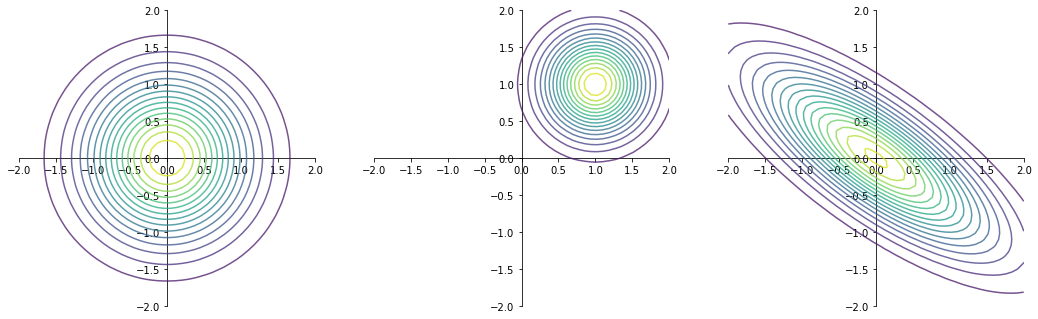

In [7]:
[a0, a1, a2] = init_plots(3, lims)
plot_model(a0, (xs, ys, gaussian_pdf(xys, m0, S0)))
plot_model(a1, (xs, ys, gaussian_pdf(xys, m1, S1)))
plot_model(a2, (xs, ys, gaussian_pdf(xys, m2, S2)))
done_plots()

## Gaussian Mixture Distribution

$$ p({\mathbf x} \mid \mathcal{w}_1, \boldsymbol\mu_1,\, \boldsymbol\Sigma_1 \ldots \mathcal{w}_k, \boldsymbol\mu_k,\, \boldsymbol\Sigma_k ) = \sum_{i=1}^k \mathcal{w}_i \: \mathcal{N}({\mathbf x}\mid \boldsymbol\mu_i,\, \boldsymbol\Sigma_i) $$

In [8]:
def gaussian_mixture_pdf(X, ws, Ms, Ss):
    
    k = len(ws)
    p = np.zeros(X.shape[:-1])
    
    for i in range(k):
        p += ws[i] * gaussian_pdf(X, Ms[i, :], Ss[i, :, :])
    
    return p

### Example contour plots

In [9]:
Ms = np.array([m0, m1, m2])
Ss = np.array([S0, S1, S2])

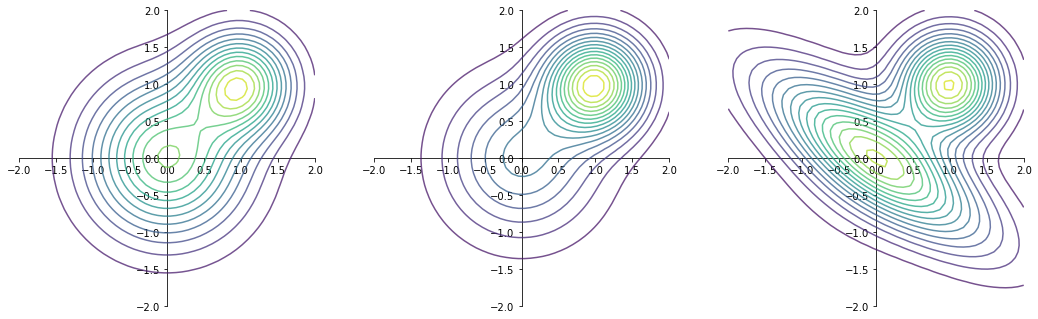

In [10]:
[a0, a1, a2] = init_plots(3, lims)
plot_model(a0, (xs, ys, gaussian_mixture_pdf(xys, [0.7, 0.3, 0.0], Ms, Ss)))
plot_model(a1, (xs, ys, gaussian_mixture_pdf(xys, [0.5, 0.5, 0.0], Ms, Ss)))
plot_model(a2, (xs, ys, gaussian_mixture_pdf(xys, [0.1, 0.3, 0.6], Ms, Ss)))
done_plots()

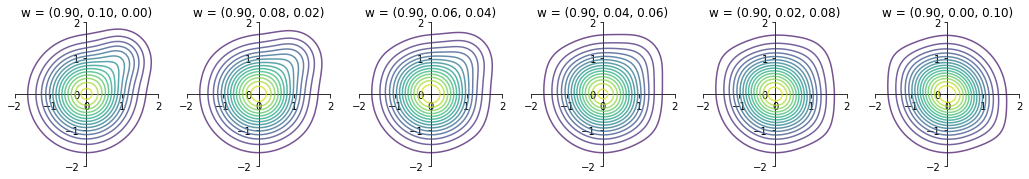

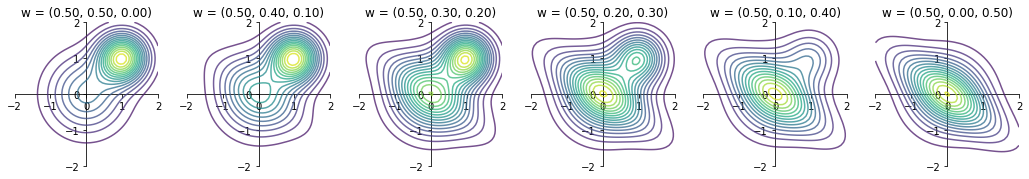

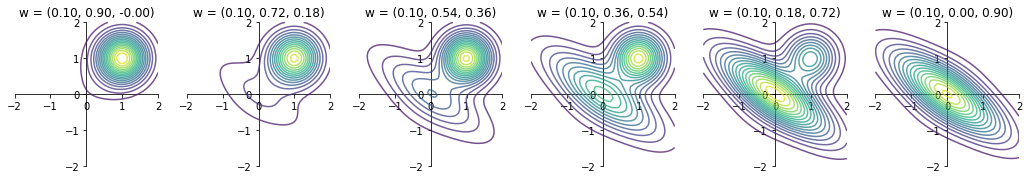

In [11]:
for w0 in np.linspace(.9, .1, 3):
    axs = init_plots(6, lims)
    for j, w1 in enumerate(np.linspace(1-w0, 0, 6)):
        ws = [w0, w1, 1-w1-w0]
        axs[j].set_title('w = (' + ', '.join(['{:0.2f}'.format(w) for w in ws]) + ')')
        plot_model(axs[j], (xs, ys, gaussian_mixture_pdf(xys, ws, Ms, Ss)))
    done_plots()

## Data set for experimentation

In [12]:
n1 = 30; m1 = np.array([0, 1]); S1 = np.array([[0.5, 0.1], [0.1, 0.5]])
n2 = 50; m2 = np.array([5, 2]); S2 = np.array([[1.0, 1.5], [1.5, 4.0]])
n3 = 80; m3 = np.array([1, 6]); S3 = np.array([[3.0, 0.0], [0.0, 1.0]])

X1 = rnd.multivariate_normal(m1, S1, n1)
X2 = rnd.multivariate_normal(m2, S2, n2)
X3 = rnd.multivariate_normal(m3, S3, n3)

X = np.vstack((X1,X2,X3))
rnd.shuffle(X)

In [13]:
xmin, xmax = X[:, 0].min() - 1, X[:, 0].max() + 1
ymin, ymax = X[:, 1].min() - 1, X[:, 1].max() + 1
lims=[xmin, xmax, ymin, ymax]

dx = xmax - xmin
dy = ymax - ymin
nx = 50
ny = int(nx * dy/dx)

xs, ys = np.meshgrid(np.linspace(lims[0], lims[1], nx),
                     np.linspace(lims[2], lims[3], ny))
xys = np.dstack((xs, ys))

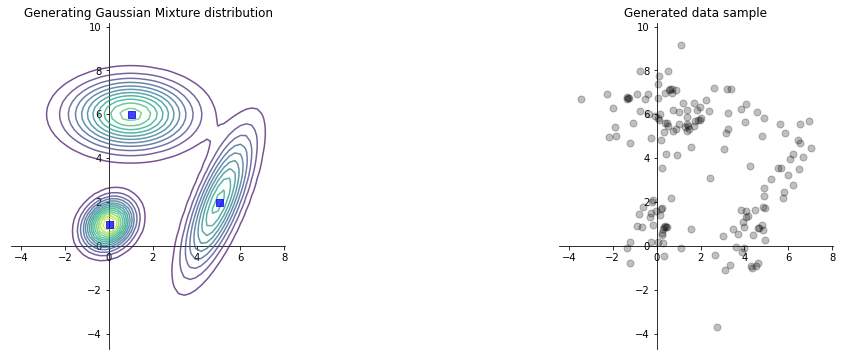

In [14]:
axs = init_plots(2, lims)

ws = np.array([n1, n2, n3]) / (n1+n2+n3)
Ms = np.array([m1, m2, m3])
Ss = np.array([S1, S2, S3])

probs = gaussian_mixture_pdf(xys, ws, Ms, Ss)
plot_model(axs[0], (xs, ys, probs))
plot_data(axs[0], None, Ms)
axs[0].set_title('Generating Gaussian Mixture distribution')

plot_data(axs[1], X, None)
axs[1].set_title('Generated data sample')
done_plots()

## MacQueen's $k$-means

We will use MacQueen's $k$-means below as a reasonable good initialization of the means. It still leaves some improvement opportunities to the expectation maximization for the Gaussian mixture model.

In [15]:
def MacQueen(X, k, show=lambda state, j, i, N, M: None):
    n, m = X.shape
    
    M = np.copy(X[:k])
    N = np.ones(k)                                                ; show('initialized', -1, -1, N, M)

    for j in range(k, n):

        i = np.argmin(np.sum((M - X[j])**2, axis=1))

        N[i] += 1
        M[i] += 1./N[i] * (X[j] - M[i])                           ; show('updated', j, i, N, M)
        
    return M

In [16]:
def plot_some_macqueen_state(n_rows, n_cols, n_data, k, 
                             state, j, i, N, M):
    
    global chunk, col, axs
    
    if state == 'initialized':
        chunk = (n_data - k - 0.1) / (n_rows * n_cols - 1)
        col = 0; j = k-1
        
    if not (j+1 - k) % chunk < 1:
        return
    
    if col == 0:
        axs = init_plots(n_cols, lims)
    
    axs[col].set_title('{} points'.format(j+1))
    plot_data(axs[col], X[:j+1], M)
    
    col += 1
    if col == n_cols: 
        done_plots(); col = 0

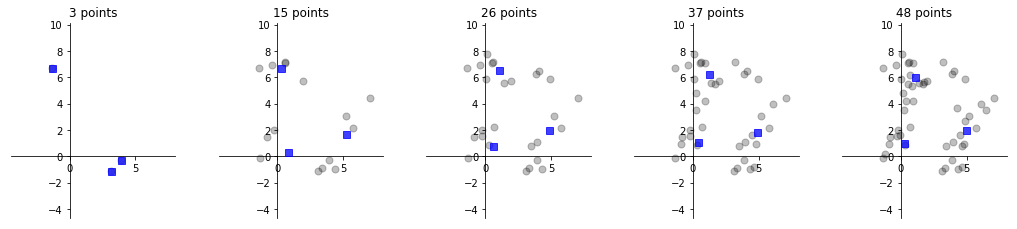

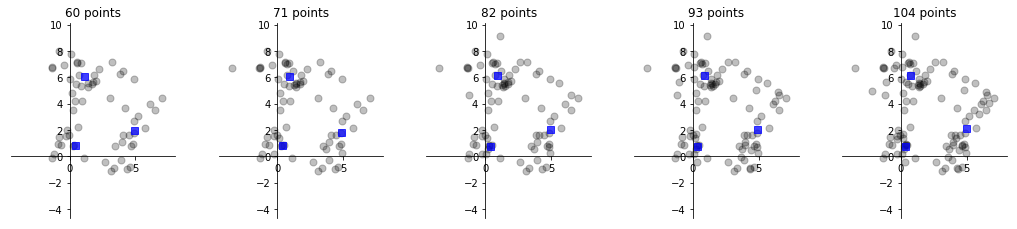

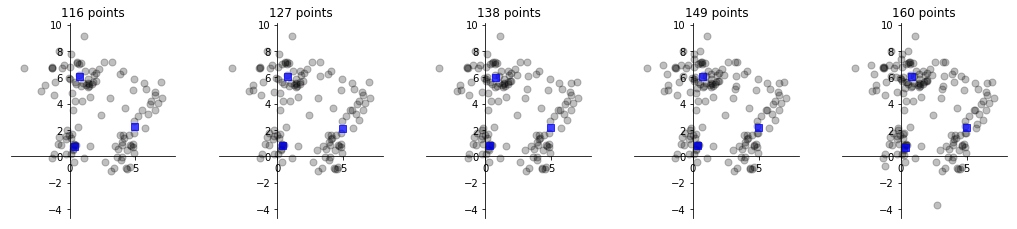

In [17]:
M = MacQueen(X, 3, show=partial(plot_some_macqueen_state, 3, 5, len(X), 3))

## Expectation Maximization for Gaussian Mixture Models

### E-Step

Equation (7) in the slides tells us to set the new probabilty of the $j$-th point being chosen from the $i$-th component of the Gaussian mixture to its relative probabilty from the $i$-th component given the other parameters.

$$ 
\zeta_{ij} \: = \:
\frac{
\mathcal{w}_i \: \mathcal{N}({\mathbf x}_j \mid \boldsymbol\mu_i,\, \boldsymbol\Sigma_i)
}{
\sum_{l=1}^k \mathcal{w}_l \: \mathcal{N}({\mathbf x}_j\mid \boldsymbol\mu_l,\, \boldsymbol\Sigma_l)
}
$$

### M-Step
The equations (8), (9), and (10) in the slides tell us to set the mean, the covariance and the weight of the $i$-th component of the Guassian mixture to the "empirical" mean, covariance and weight weighted by the given mixture probabilities.

$$ 
\mu_i \: = \:
\frac{
\sum_{j} \zeta_{ij} {\mathbf x}_j
}{
\sum_{j} \zeta_{ij}
}
, \qquad
\Sigma_i \: = \:
\frac{
\sum_{j} \zeta_{ij} ({\mathbf x}_j - \mu_i)({\mathbf x}_j - \mu_i)^T
}{
\sum_{j} \zeta_{ij}
}
, \qquad
\mathcal{w}_i \: = \:
\frac{
\sum_{j} \zeta_{ij}
}{
n
}
$$

In [18]:
def gmm_expectation_maximization(X, T, M, show=lambda state, t, Z, w, M, S: None):

    n, m = X.shape
    k = M.shape[0]

    w = np.ones(k)/ k
    S = np.array([np.identity(m) for i in range(k)])
    Z = np.zeros((k, n))

    for t in range(T):

        show('before E-Step', t, Z, w, M, S)
        
        for i in range(k):
            Z[i] = w[i] * gaussian_pdf(X, M[i], S[i])
        Z /= np.sum(Z, axis=0)
        
        show('before M-Step', t, Z, w, M, S)
        
        for i in range(k):
            D = X - M[i]
            M[i] =  Z[i].T.dot(X)      / np.sum(Z[i])
            S[i] = (Z[i] * D.T).dot(D) / np.sum(Z[i])
            w[i] = np.sum(Z[i]) / n
    
    show('done', t, Z, w, M, S)
    
    return w, M, S

In [19]:
def plot_em_state(n_cols, state, t, Z, w, M, S):

    global col, axs

    if state == 'before E-Step' and t == 0:
        col = 0
    
    if not(state in ['before E-Step', 'done']):
        return
    
    if col == 0:
        axs = init_plots(n_cols, lims)
    
    axs[col].set_title(('After {} iterations'.format(t+1) if state == 'done' else 't = {}'.format(t)))
    plot_data(axs[col], X, M)
    plot_model(axs[col], (xs, ys, gaussian_mixture_pdf(xys, w, M, S)))

    col += 1
    if col == n_cols:
        done_plots()
        col = 0

## Good initialization leads to good results

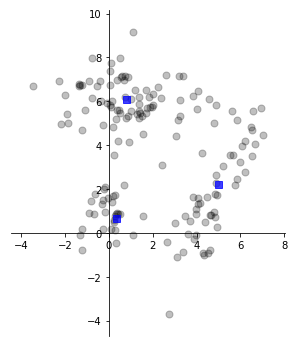

In [20]:
M = MacQueen(X, 3)
plot_data(init_plots(1, lims), X, M); done_plots()

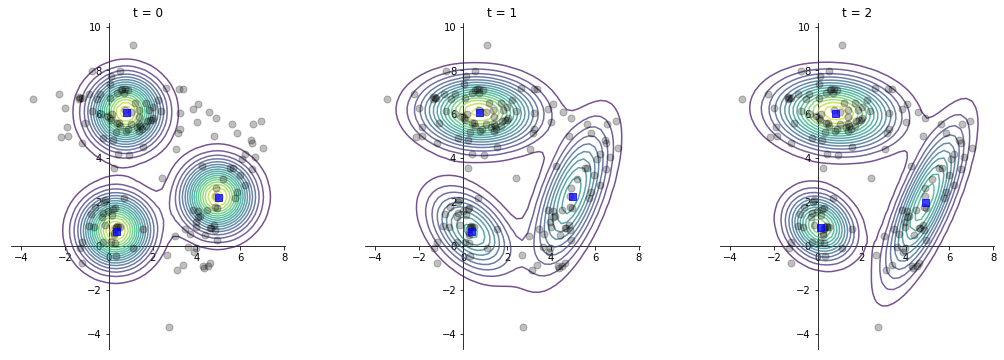

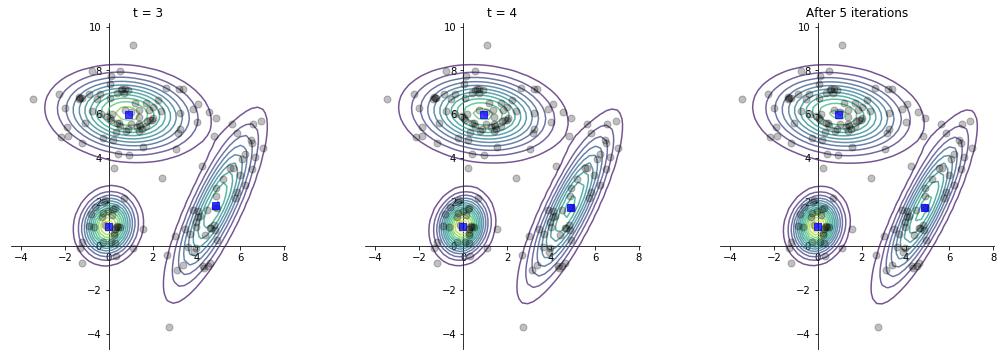

In [21]:
w_good, M_good, S_good = gmm_expectation_maximization(X, 5, M, show=partial(plot_em_state, 3))

## Bad initialization leads to suboptimal results

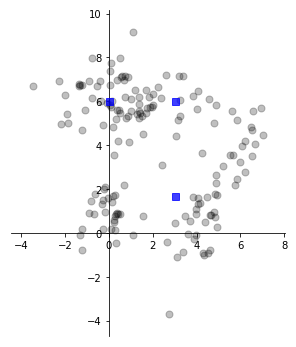

In [22]:
M = np.array([[0.0, 6.0], [3.0, 6.0], [3.0, 1.7]])
plot_data(init_plots(1, lims), X, M); done_plots()

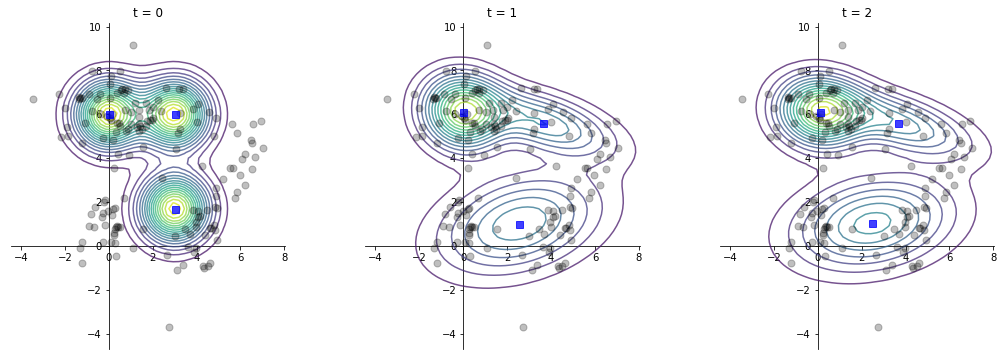

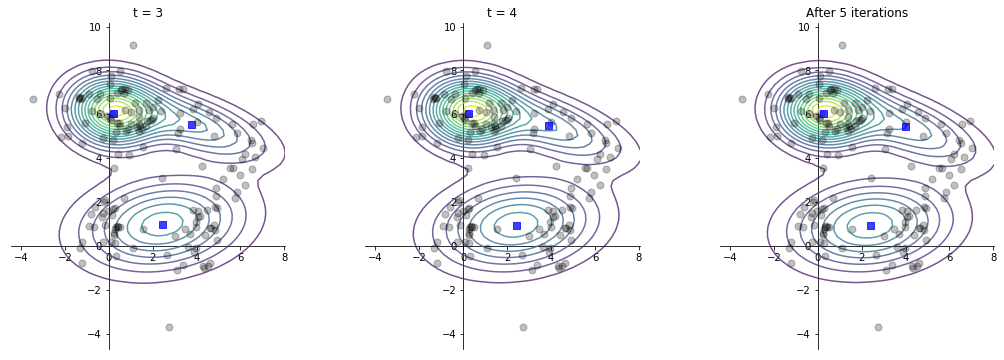

In [23]:
w_bad, M_bad, S_bad = gmm_expectation_maximization(X, 5, M, show=partial(plot_em_state, 3))

## EM will fit any model - reasonable or not

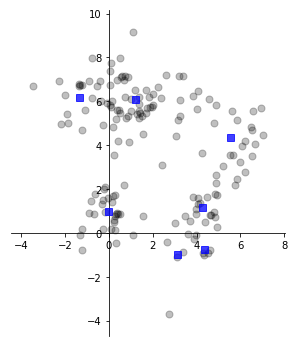

In [24]:
M = MacQueen(X, 7)
plot_data(init_plots(1, lims), X, M); done_plots()

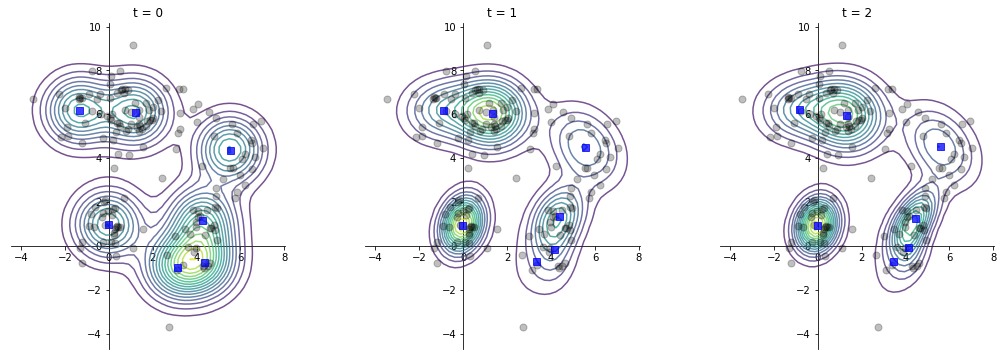

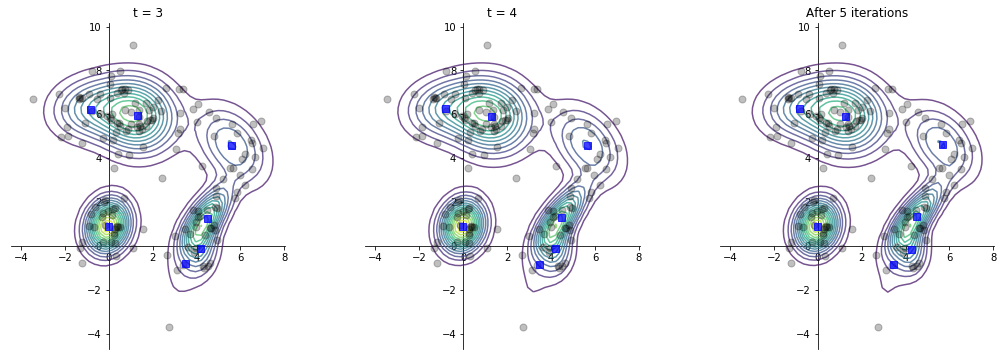

In [25]:
w_any, M_any, S_any = gmm_expectation_maximization(X, 5, M, show=partial(plot_em_state, 3))

## Comparison of the three results

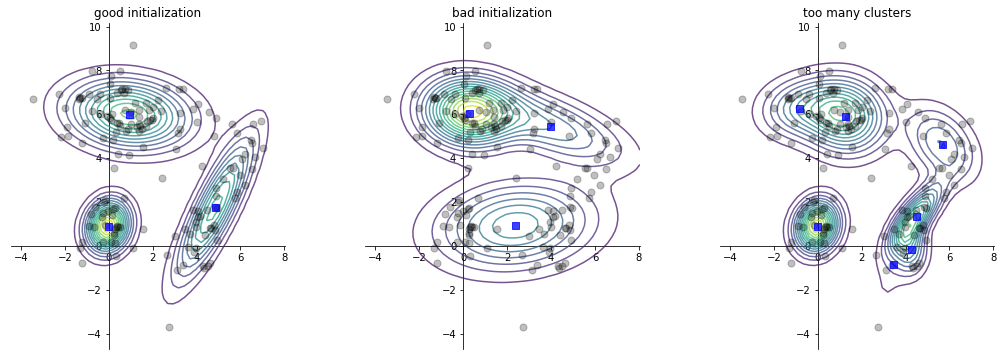

In [26]:
axs = init_plots(3, lims)
plot_data(axs[0], X, M_good); axs[0].set_title('good initialization')
plot_data(axs[1], X, M_bad);  axs[1].set_title('bad initialization')
plot_data(axs[2], X, M_any);  axs[2].set_title('too many clusters')
plot_model(axs[0], (xs, ys, gaussian_mixture_pdf(xys, w_good, M_good, S_good)))
plot_model(axs[1], (xs, ys, gaussian_mixture_pdf(xys, w_bad,  M_bad,  S_bad)))
plot_model(axs[2], (xs, ys, gaussian_mixture_pdf(xys, w_any,  M_any,  S_any)))
done_plots()

<table style="width:100%">
  <tr>
      <td colspan="1" style="text-align:left;background-color:#0071BD;color:white">
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">
            <img alt="Creative Commons License" style="border-width:0;float:left;padding-right:10pt"
                 src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" />
        </a>
        &copy; C. Bauckhage, O. Cremers, dsp<br/>
        Licensed under a 
        <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/" style="color:white">
            CC BY-NC 4.0
        </a>.
      </td>
      <td colspan="2" style="text-align:left;background-color:#66A5D1">
          <b>Acknowledgments:</b>
          This material was prepared within the project
          <a href="http://www.b-it-center.de/b-it-programmes/teaching-material/p3ml/" style="color:black">
              P3ML
          </a> 
          which is funded by the Ministry of Education and Research of Germany (BMBF)
          under grant number 01/S17064. The authors gratefully acknowledge this support.
      </td>
  </tr>
</table>